# Changing Turbine Governor Setpoints

This notebook shows an example of changing the generator setpoints in a time-domain simulation. Data in this example is trivial, but the example can be retrofitted for scenarios such as economic dispatch incorporation or reinforcement learning.

Steps are the folllwing:

1. Initialize a system by running the power flow,
2. Set the first simulation stop time in `TDS.config.tf`,
3. Run the simulation,
3. Update the setpoints,
4. Set the new simulation stop time and repeat from 3 until the end.

## Step 1: Case Setup

In [1]:
import andes
from andes.utils import get_case

In [2]:
kundur = get_case('kundur/kundur_full.xlsx')

ss = andes.run(kundur)

Working directory: "/home/hcui7/repos/andes/examples"


Loaded config from file "/home/hcui7/.andes/andes.rc"


Loaded generated Python code in "~/.andes/pycode".


Parsing input file "/home/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx"...


Input file parsed in 0.4004 seconds.


System internal structure set up in 0.0391 seconds.


-> System connectivity check results:


  No islanded bus detected.


  A total of 1 island(s) detected.


  Each island has a slack bus correctly defined and enabled.



-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
 Sparse addition: Fast in-place (kvxopt)


Power flow initialized.


0: |F(x)| = 14.9282832


1: |F(x)| = 3.608627841


2: |F(x)| = 0.1701107882


3: |F(x)| = 0.002038626956


4: |F(x)| = 3.745103977e-07


Converged in 5 iterations in 0.0080 seconds.


Report saved to "kundur_full_out.txt" in 0.0019 seconds.


-> Single process finished in 0.6596 seconds.


In [3]:
# disable the Toggler in this case
ss.Toggler.alter('u', 1, 0)

## Step 2: Set the First Stop Time

In [4]:
# simulate to t=1 sec

# specify the first stop in `ss.TDS.config.tf`
ss.TDS.config.tf = 1

## Step 3: Run Simulation

In [5]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


Initialization for dynamics was successful in 0.0222 seconds.


  0%|                                          | 0/100 [00:00<?, ?%/s]

100%|██████████████████████████████| 100/100 [00:00<00:00, 1059.54%/s]

Simulation completed in 0.0958 seconds.


Outputs to "kundur_full_out.lst" and "kundur_full_out.npz".


Outputs written in 0.0049 seconds.


True

## Step 4. Apply the auxiliary power setpoints to `TGOV1.paux0.v`

First, let's check the equations of TGOV1. `ss.TGOV1.paux0` is associated with equation `0 = paux - paux0`, in which `paux` is added to the power input equation.

In [6]:
print(ss.TGOV1.doc())

Model <TGOV1> in Group <TurbineGov>

    TGOV1 turbine governor model.

    Implements the PSS/E TGOV1 model without deadband.
    
Parameters

 Name  |            Description            | Default | Unit |    Properties   
-------+-----------------------------------+---------+------+-----------------
 idx   | unique device idx                 |         |      |                 
 u     | connection status                 | 1       | bool |                 
 name  | device name                       |         |      |                 
 syn   | Synchronous generator idx         |         |      | mandatory,unique
 Tn    | Turbine power rating. Equal to    |         | MVA  |                 
       | `Sn` if not provided.             |         |      |                 
 wref0 | Base speed reference              | 1       | p.u. |                 
 R     | Speed regulation gain (mach. base | 0.050   | p.u. | ipower          
       | default)                          |         |      |     

In [7]:
ss.TGOV1.paux0.v

array([0., 0., 0., 0.])

In [8]:
# look up the original values of TGOV1 make sure they are as expected

ss.TGOV1.paux0.v

array([0., 0., 0., 0.])

In [9]:
# MUST use in-place assignments. 
# Here, we increase the setpoint of the 0-th generator

# method 1: use in-place assignment again

ss.TGOV1.paux0.v[0] = 0.05

# method 2: use ``ss.TGOV1.alter()``

# ss.TGOV1.alter('paux0', 1, 0.05)

In [10]:
ss.TGOV1.paux0.v

array([0.05, 0.  , 0.  , 0.  ])

Continue to simulate to 2 seconds.

In [11]:
ss.TDS.config.tf = 2

In [12]:
ss.TDS.run()

  0%|                                          | 0/100 [00:00<?, ?%/s]

 71%|█████████████████████▎        | 71.0/100 [00:00<00:00, 694.99%/s]

100%|█████████████████████████████| 100.0/100 [00:00<00:00, 321.79%/s]

Simulation completed in 0.3137 seconds.


Outputs to "kundur_full_out.lst" and "kundur_full_out.npz".


Outputs written in 0.0058 seconds.


True

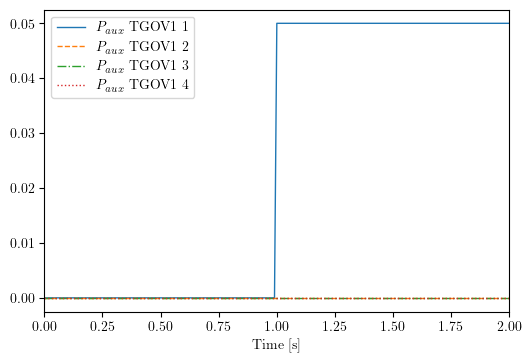

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [13]:
ss.TDS.plotter.plot(ss.TGOV1.paux)

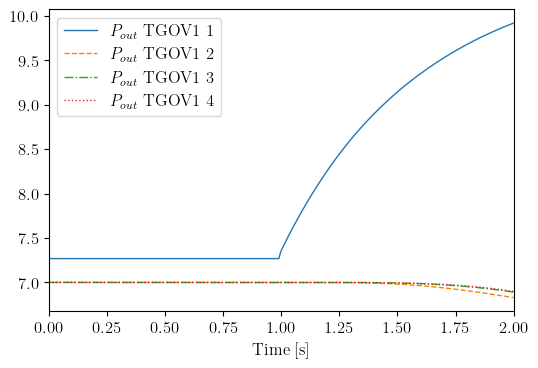

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [14]:
ss.TDS.plotter.plot(ss.TGOV1.pout)

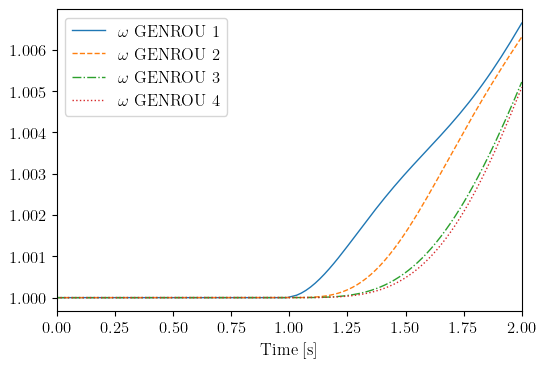

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [15]:
ss.TDS.plotter.plot(ss.GENROU.omega)

## Step 5: Set Another New Setpoints and New Ending TIme.

In this example, we clear the auxiliary power previously set to `TGOV1.paux0.v`

In [16]:
# method 1: use in-place assignment again

ss.TGOV1.paux0.v[0] = 0.

# method 2: use ``ss.TGOV1.alter()``

# ss.TGOV1.alter('paux0', 1, 0)

# set the new ending time to 10 sec.
ss.TDS.config.tf = 10

In [17]:
ss.TDS.run()

  0%|                                          | 0/100 [00:00<?, ?%/s]

 23%|██████▉                       | 23.0/100 [00:00<00:00, 220.82%/s]

 46%|██████████████▎                | 46.0/100 [00:00<00:00, 88.64%/s]

 59%|██████████████████▎            | 59.0/100 [00:00<00:00, 83.34%/s]

 70%|█████████████████████▋         | 70.0/100 [00:00<00:00, 72.36%/s]

 79%|████████████████████████▍      | 79.0/100 [00:01<00:00, 68.30%/s]

 87%|██████████████████████████▉    | 87.0/100 [00:01<00:00, 65.50%/s]

 95%|█████████████████████████████▍ | 95.0/100 [00:01<00:00, 63.64%/s]

100%|██████████████████████████████| 100.0/100 [00:01<00:00, 73.43%/s]

Simulation completed in 1.3651 seconds.


Outputs to "kundur_full_out.lst" and "kundur_full_out.npz".


Outputs written in 0.0614 seconds.


True

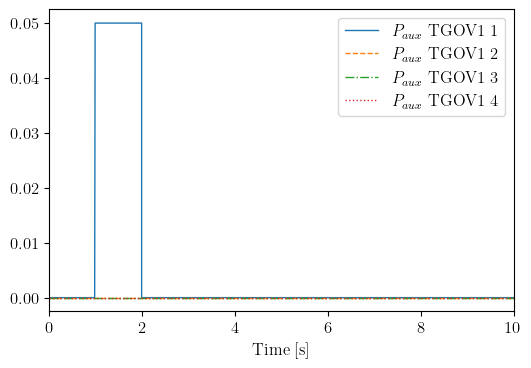

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [18]:
ss.TDS.plotter.plot(ss.TGOV1.paux)

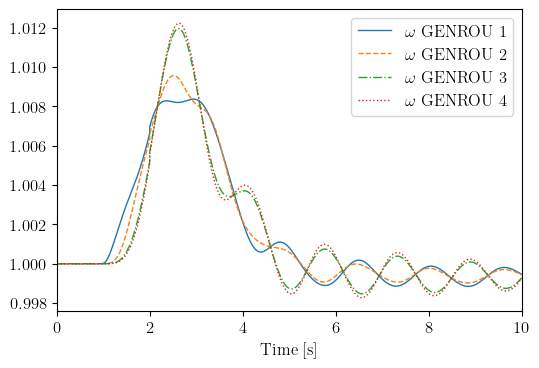

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [19]:
ss.TDS.plotter.plot(ss.GENROU.omega)

In [20]:
!andes misc -C


    _           _         | Version 1.4.2.post116.dev0+g832274a7
   /_\  _ _  __| |___ ___ | Python 3.9.6 on Linux, 09/26/2021 05:41:58 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

"/home/hcui7/repos/andes/examples/kundur_full_out.txt" removed.
"/home/hcui7/repos/andes/examples/kundur_full_out.npz" removed.
"/home/hcui7/repos/andes/examples/kundur_full_out.lst" removed.
